### Optical pulse broadening in optical fiber

samplerate: 131072
N: 262144
t_step: 2e-16
frequencystep:  19073486328.125
frequencystep:  1.90735E+10
Shape of UnShifted_f: (131072,)
Nyq_freq: 2.50000E+15


C:\Users\swako\AppData\Local\Temp\ipykernel_23660\3743625344.py:37: RuntimeWarning: divide by zero encountered in divide
  wavelengths = (1e6 * c)/ optical_frequencies
C:\Users\swako\AppData\Local\Temp\ipykernel_23660\3743625344.py:39: RuntimeWarning: invalid value encountered in divide
  indexes_quartz = np.sqrt(1 + 0.708395 * wavelengths**2/(wavelengths)**2 - 0.00729) + 0.420399 * wavelengths**2/(wavelengths**2 - 0.01050) + 0.866341 * wavelengths**2/(wavelengths**2 - 97.93428)
C:\Users\swako\AppData\Local\Temp\ipykernel_23660\3743625344.py:52: RuntimeWarning: divide by zero encountered in divide
  phase_change = (2 * np.pi * indexes_quartz1 * thickness) / ((1e6 * c)/ optical_frequencies)


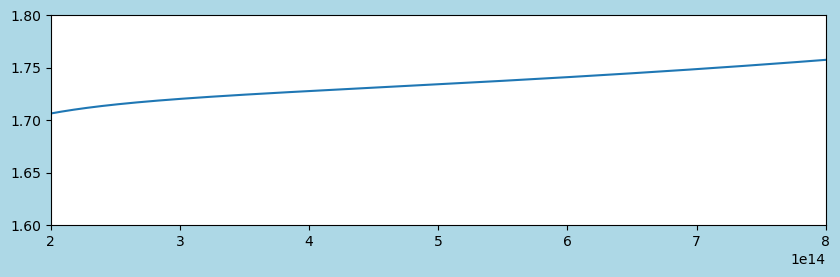

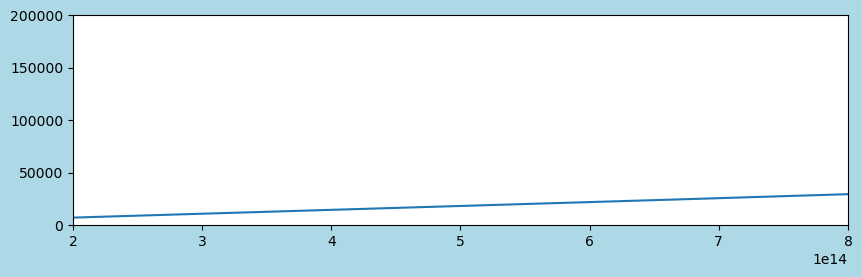

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.constants import c 


samplerate = 2**17 # Number of Points
print('samplerate:', samplerate)

N = 2* samplerate
print('N:', N)

t_step = 2e-16 #[s]
print('t_step:', t_step)
tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)


frequencystep = (1/t_step) * (1/N)
print("frequencystep: ", frequencystep)
print("frequencystep: ", f'{frequencystep:.5E}')

UnShifted_sampleIndex = np.arange(0, N//2)
UnShifted_f = UnShifted_sampleIndex*frequencystep

print('Shape of UnShifted_f:', UnShifted_f.shape)

Nyq_freq = samplerate * frequencystep
print('Nyq_freq:', f'{Nyq_freq:.5E}')

optical_frequencies = np.linspace(0, Nyq_freq, samplerate)




def indexes_quartz(optical_frequencies):
    
    wavelengths = (1e6 * c)/ optical_frequencies

    indexes_quartz = np.sqrt(1 + 0.708395 * wavelengths**2/(wavelengths)**2 - 0.00729) + 0.420399 * wavelengths**2/(wavelengths**2 - 0.01050) + 0.866341 * wavelengths**2/(wavelengths**2 - 97.93428)
  
    return indexes_quartz


#wavelengths = np.linspace(0.4, 0.7, 1000)
# Constants
indexes_quartz1 = indexes_quartz(optical_frequencies)  # Refractive index of water
thickness = 1e3  # Thickness of water layer in meters

# Wavelength range in visible spectrum (400 nm to 700 nm)

# Calculate phase change
phase_change = (2 * np.pi * indexes_quartz1 * thickness) / ((1e6 * c)/ optical_frequencies)

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, indexes_quartz1)
ax1_1.set_xlim(200e12, 800e12)
ax1_1.set_ylim(1.6,1.8)



fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(optical_frequencies, phase_change)
ax2_1.set_xlim(200e12, 800e12)
ax2_1.set_ylim(0,200000)
plt.show()



[1.5000000e+14 1.5002442e+14 1.5004884e+14 ... 2.4995116e+14 2.4997558e+14
 2.5000000e+14]
[1.99861639e-06 1.99829106e-06 1.99796585e-06 ... 1.19940415e-06
 1.19928698e-06 1.19916983e-06]
[9.42477796e+14 9.42631232e+14 9.42784667e+14 ... 1.57048946e+15
 1.57064289e+15 1.57079633e+15]
[1.67195635 1.67196975 1.67198314 ... 1.69926444 1.69926787 1.69927131]
[1.7547696  1.75475429 1.75473899 ... 1.73404858 1.73404754 1.7340465 ]
[-0.09358035 -0.0935243  -0.0934683  ... -0.0110603  -0.01105482
 -0.01104934]


Text(0, 0.5, 'D [ps/(nm*km)]um')

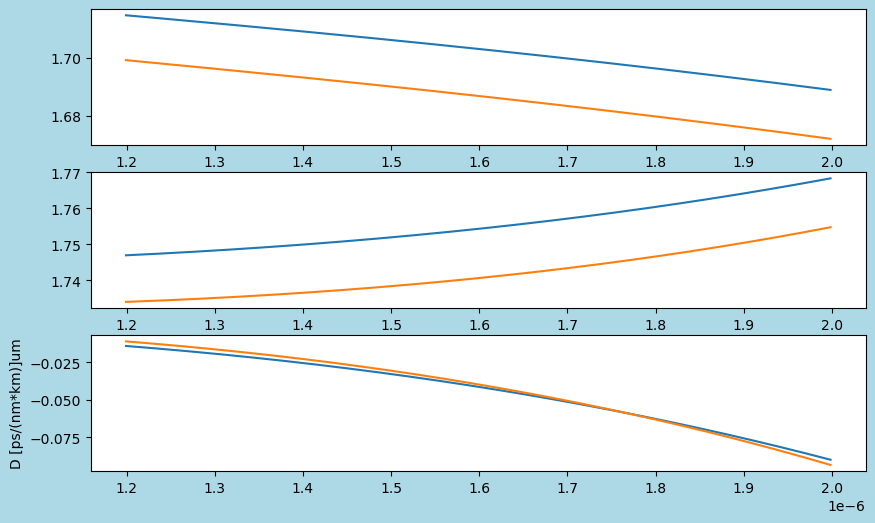

In [51]:


#import optical_pulse_broadening_in_optical_fibers_def
from sellmeier_def import sellmeiercore, sellmeierclad

mm = 4096 # 2048, 4096, 8192, 16384

#startfreq = 194e12
#stopfreq = 194.05e12
startfreq = 150e12
stopfreq = 250e12

freqcol = np.linspace(startfreq,stopfreq, mm)
wlcol = c / freqcol
omegacol = 2*np.pi * freqcol
kcol = np.zeros(mm)

print(freqcol)
print(wlcol)
print(omegacol)

ncorecol, Ncorecol, scorecol = sellmeiercore(1e6*wlcol)	#get index !! input wavelength as um

ncladcol, Ncladcol, scladcol = sellmeierclad(1e6*wlcol)	#get index !! input wavelength as um

betacol = kcol
#betacol = kcol* np.sqrt((ncladcol)**2 + ((ncorecol)**2 - (ncladcol)**2))

distance = 1 * 1000

print(ncladcol)
print(Ncladcol)
print(scladcol)


fig4 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax4_1 = fig4.add_subplot(3, 1, 1)
ax4_2 = fig4.add_subplot(3, 1, 2)
ax4_3 = fig4.add_subplot(3, 1, 3)

ax4_1.plot(wlcol, ncorecol, wlcol, ncladcol,)

ax4_2.plot(wlcol, Ncorecol, wlcol, Ncladcol)

ax4_3.plot(wlcol, scorecol, wlcol, scladcol)
ax4_3.set_ylabel("D [ps/(nm*km)]um")


In [52]:

# c = 2.99792458 * 1e8;	%m/sec
#  centerfreq = 194.05*1e12;
#  widthfreq = 1000*1e9;	%Hz

#startfreq = centerfreq - 0.5.* widthfreq
# stepfreq = widthfreq / mm; % Hz
 

#  eyezoomin = 6;
#  NRZ = 50;
#   judgevoltage = 0.5;
#   bitrate = 10e9; %1073741824	% bps;
#   timeperbit = 1/(bitrate)
#  pulsestowatch = 10;
#b = 0.0;
   
"""
[ncorecol, Ncorecol, scorecol] = sellmeiercore(wlcol)	#get index !! input wavelength as um
betacorecol = kcol* ncorecol

[ncladcol, Ncladcol, scladcol] = sellmeierclad(wlcol)	#get index !! input wavelength as um
betacladcol = kcol* ncladcol;

betacol = kcol* np.sqrt((ncladcol).^2 + ((ncorecol).^2 - (ncladcol).^2) .* b)
  
 
polyfitbeta = np.polyfit(omegacol,betacol,3) #fitting by 3rd order
betaestcol = np.polyval(polyfitbeta,omegacol)# get
 
dpolyfitbeta = np.polyder(polyfitbeta)#;%derivate
dbetadomegacol = np.polyval(dpolyfitbeta,omegacol)#;%get
 
fig4 = plt.figure(figsize = (10,6), facecolor='lightblue')
#set(fig2,'Position',[100 400 600 300])

plot(1e-12.* omegacol,1.0001e-6.* betacol,'r-',...
   1e-12.* omegacol,1e-6.* betaestcol,'g-',...
      1e-12.* omegacol,1e-6.* betacorecol,'b-',...
   1e-12.* omegacol,1e-6.* betacladcol,'y-');

xlabel('T [Hz]','FontSize',12); 	ylabel('beta [rad / m]','FontSize',9);
  
fig5 = plt.figure(figsize = (10,6), facecolor='lightblue')

#plot(1e-12.* omegacol,dbetadomegacol);
#xlabel('T','FontSize',9);  
#ylabel('dbetadomega','FontSize',9);

 polyfitdbetadomega = polyfit(omegacol,dbetadomegacol,2);%fitting
 dpolyfitbetadomega = polyder(polyfitdbetadomega);%derivate
 ddbetaddomegacol = polyval(dpolyfitbetadomega,omegacol);%get


fig5 = plt.figure(figsize = (10,6), facecolor='lightblue')

set(fig3,'Position',[320 50 500 320])
plot(1e-12.* freqcol, 1e24.* ddbetaddomegacol); 
% probably correct !! p.73 of NTT book.
xlabel('freq [THz]','FontSize',9);
ylabel('ddbetaddomega [ps^2 / m] ','FontSize',9);

 Dcol = -1.* omegacol.* ddbetaddomegacol ./ wlcol;

fig6 = plt.figure(figsize = (10,6), facecolor='lightblue')
set(fig4,'Position',[320 50 500 320])
plot(1e-12.* freqcol, 1e6.* Dcol); 
% probably correct !! p.73 of NTT book.
xlabel('freq [THz]','FontSize',9);
ylabel('D [ps/(nm*km)]','FontSize',12);


tstep = 1/(stepfreq*mm*1) # sec I think this sould be 1 !! not 2 !!!!


resolutionperpulse = timeperbit / tstep
[tcol, pulsescol] = signalgenerate_square(mm, tstep, bitrate, resolutionperpulse, NRZ);

fftpulsescol = (fft(pulsescol));
freqmax = 1/tstep 
fcol = [freqmax/mm : freqmax/mm : freqmax]';

fig7 = plt.figure(figsize = (10,6), facecolor='lightblue')
set(fig5,'Position',[320 400 600 270])
plot(1e-9*fcol, abs(fftpulsescol).^2)
xlabel(' GHz','FontSize',9);
xlim([0 1.0*1e-9* freqmax])
title('Power');
% make profile

nfftpulsescol = [fftpulsescol(0.5*mm+1:mm);fftpulsescol(1:0.5*mm)];

fig8 = plt.figure(figsize = (10,6), facecolor='lightblue')
set(fig7,'Position',[320 50 300 270])
plot(1e-9*fcol, abs(nfftpulsescol).^2)
xlabel('GHz');title('Power');

#___________________________________________________________

expFcol = np.zeros(mm);
for ii = 1:mm
   gamma = 0.5 .* ddbetaddomegacol(ii) .* omegacol(ii).^2;
   expF = exp(-j.* gamma .* distance) .* nfftpulsescol(ii) ;
   %expF = nfftpulsescol(ii);

   expFcol(ii,1) = expF;
end

fig9 = plt.figure(figsize = (10,6), facecolor='lightblue')
#set(fig8,'Position',[320 50 700 270])
#plot(abs(nfftpulsescol) + 100,'r');hold on;
#plot(abs(expFcol), 'b');hold off;

nexpFcol = [expFcol(0.5*mm+1:mm);expFcol(1:0.5*mm)];
ifftnexpFcol = ifft(nexpFcol);

fig10 = plt.figure(figsize = (10,6), facecolor='lightblue')

set(fig9,'Position',[20 50 1100 270])
plot(1e9.* tcol,abs(pulsescol).^2,'r-',...
   1e9.* tcol,abs(ifftnexpFcol).^2,'b-');%,1e9.* tcol,real(pulses2col),'g-')
xlabel(' nanosec','FontSize',9);grid on;
title('Power');
maxt = 1e9.* max(tcol)
xlim([0, timeperbit * pulsestowatch *1e9])
ylim([0, 2])

eyepatternstep = resolutionperpulse * 1.5
ttcol = zeros(mm,1);
for ii = 1:mm
   tt = mod(ii,eyepatternstep);  
   ttcol(ii,1) = tt * tstep;
end


#fig11 = plt.figure(figsize = (10,6), facecolor='lightblue')
#set(fig10,'Position',[20 100 600 270]);
#plot(1e9.* ttcol,abs(pulsescol).^2,'r.',1e9.* ttcol,abs(ifftnexpFcol).^2,'b.-',...
#   1e9.* tstep .* [eyezoomin eyezoomin],[0,1.5],'g-');
#xlabel(' nanosec','FontSize',9);grid on;
#title('Power');

#      [nvaluzerocol, nvaluonecol] =...
#   eyepattern_func(mm, ifftnexpFcol, eyepatternstep, eyezoomin, judgevoltage);


   
#   [meanzero, stdzero, meanone, stdone, Q, ber] = ...
#      getber(nvaluzerocol, nvaluonecol)
#disp('****************************************************')
   

#fig12 = plt.figure(figsize = (10,6), facecolor='lightblue')
#%set(fig11,'Position',[20 100 600 270])
#%stem(valucol,'o-');
"""

"\n[ncorecol, Ncorecol, scorecol] = sellmeiercore(wlcol)\t#get index !! input wavelength as um\nbetacorecol = kcol* ncorecol\n\n[ncladcol, Ncladcol, scladcol] = sellmeierclad(wlcol)\t#get index !! input wavelength as um\nbetacladcol = kcol* ncladcol;\n\nbetacol = kcol* np.sqrt((ncladcol).^2 + ((ncorecol).^2 - (ncladcol).^2) .* b)\n  \n \npolyfitbeta = np.polyfit(omegacol,betacol,3) #fitting by 3rd order\nbetaestcol = np.polyval(polyfitbeta,omegacol)# get\n \ndpolyfitbeta = np.polyder(polyfitbeta)#;%derivate\ndbetadomegacol = np.polyval(dpolyfitbeta,omegacol)#;%get\n \nfig4 = plt.figure(figsize = (10,6), facecolor='lightblue')\n#set(fig2,'Position',[100 400 600 300])\n\nplot(1e-12.* omegacol,1.0001e-6.* betacol,'r-',...\n   1e-12.* omegacol,1e-6.* betaestcol,'g-',...\n      1e-12.* omegacol,1e-6.* betacorecol,'b-',...\n   1e-12.* omegacol,1e-6.* betacladcol,'y-');\n\nxlabel('T [Hz]','FontSize',12); \tylabel('beta [rad / m]','FontSize',9);\n  \nfig5 = plt.figure(figsize = (10,6), facecol